In [1]:
import torch
import sys
from LogSinkhornGPU import *
import time
import matplotlib.pyplot as plt
plt.rc('font', size=12) #controls default text size

def benchmark_2D_random(n, B, Niter, eps):
    M1 = M2 = N1 = N2 = n
    M = M1*M2
    N = N1*N2
    mu = torch.rand(B, M1, M2, device = "cuda") + 1
    nu = torch.rand(B, N1, N2, device = "cuda") + 1
    mu = mu/torch.sum(mu, dim = (1,2), keepdim = True)
    nu = nu/torch.sum(nu, dim = (1,2), keepdim = True)
    x1 = torch.linspace(0,1,M1, device = "cuda")
    x2 = torch.linspace(0,1,M2, device = "cuda")
    y1 = torch.linspace(0,1,N1, device = "cuda")
    y2 = torch.linspace(0,1,N2, device = "cuda")

    # Get point clouds for point-cloud solvers
    X = torch.cartesian_prod(x1, x2) # Same as meshgrid, raveling and concatting
    Y = torch.cartesian_prod(y1, y2)
    X = X[None, :, :] # Add batch dimension
    Y = Y[None, :, :] # Add batch dimension
    
    results = torch.zeros(5)
    errors = torch.zeros(5)
    # Check size fits in memory
    if (B*n**4) <= 2**27:
        # Dense solver
        # cost must be of shape (B, M, N), or (1, M, N) if it is the same for all problems
        C_dense = torch.sum((X.reshape(1, -1, 1, 2) - Y.reshape(1, 1, -1, 2))**2, dim = 3).reshape(1, M, N)
        # marginals must be of shape (B, M) and (B, N)
        solver_dense = LogSinkhornTorch(mu.reshape(B, -1), nu.reshape(B, -1), C_dense, eps)
        time0 = time.time()
        solver_dense.iterate(Niter)
        results[0] = time.time() - time0
        # Save reference first potential
        a_ref = solver_dense.alpha.reshape(B, M1, M2)
        errors[0] = 0
    else: # If size is too big for dense solver
        results[0] = torch.nan 
        a_ref = torch.nan
        errors[0] = torch.nan
    
    # Torch grid
    if (B*n**3) <= 2**27:
        # TorchImage requires cost along each dimension
        C1 = (x1.reshape(-1,1) - y1.reshape(1, -1))**2
        C2 = (x2.reshape(-1,1) - y2.reshape(1, -1))**2
        C_grid = (C1, C2)
        # mu and nu must have the "geometric" shape, i.e. (B, M1, M2), (B, N1, N2)
        solver_grid = LogSinkhornTorchImage(mu, nu, C_grid, eps)
        time0 = time.time()
        solver_grid.iterate(Niter)
        a_grid = solver_grid.alpha.reshape(B, M1, M2)
        errors[1] = torch.sum(torch.abs(a_ref - a_grid))/(B*M)
        results[1] = time.time() - time0
    else: 
        results[1] = torch.nan
        errors[1] = torch.nan
    #print("Error torch image: ", solver_grid.get_current_error())

    # Keops
    if (B*n**3) <= 2**27:
        # For the keops solver the cost is encoded by the points cloud coordinates themselves. 
        # Then the cost entries are computed online
        C_keops = (X.contiguous(), Y.contiguous())
        solver_keops = LogSinkhornKeops(mu.reshape(B, -1), nu.reshape(B, -1), C_keops, eps)
        time0 = time.time()
        solver_keops.iterate(Niter)
        results[2] = time.time() - time0
        a_keops = solver_keops.alpha.reshape(B, M1, M2)
        errors[2] = torch.sum(torch.abs(a_ref - a_keops))/(B*M)
    else:
        results[2] = torch.nan
        errors[2] = torch.nan
    #print("Error keops: ", solver_keops.get_current_error())

    # Keops grid
    # For the keops grid solver we pass the coordinates of the grid accross each dimension
    # The cost is then computed online
    xs = (x1,x2)
    ys = (y1,y2)
    solver_keops_image = LogSinkhornKeopsImage(mu, nu, (xs, ys), eps)
    time0 = time.time()
    solver_keops_image.iterate(Niter)
    results[3] = time.time() - time0
    a_keops_image = solver_keops_image.alpha.reshape(B, M1, M2)
    errors[3] = torch.sum(torch.abs(a_ref - a_keops_image))/(B*M)

    # CUDA
    # For the cuda solver we just pass the pixelsize, i.e. the distance between consecutive grid points. 
    # For this to produce the correct solution, the grids must start at the origin and have regular spacing
    # between consecutive points. If the grids do not start at the origin, some preprocessing and post processing
    # is needed; this is detailed in the example `cuda_solver_offset`.
    dx = float(x1[1] - x1[0])
    solver_cuda_image = LogSinkhornCudaImage(mu, nu, dx, eps)
    time0 = time.time()
    solver_cuda_image.iterate(Niter)
    results[4] = time.time() - time0
    a_cuda = solver_cuda_image.alpha.reshape(B, M1, M2)
    errors[4] = torch.sum(torch.abs(a_ref - a_cuda))/(B*M)
    print(results/Niter)
    #print(errors)
    return results/Niter, errors


In [2]:
B = 1
eps = 0.001
ns =     torch.tensor([16,     32,  64, 128, 256, 512, 1024, 2048])
Niters = [512,   256, 128,  64,  32,  16,   32,   32]
results = torch.zeros((len(ns), 5))

print("Batchsize == 1")
for i in range(len(ns)):
    N = ns[i]
    Niter = Niters[i]
    res, error = benchmark_2D_random(N, B, Niter, eps)
    results[i, :] = res

Batchsize == 1
tensor([0.0003, 0.0006, 0.0014, 0.0027, 0.0002])
tensor([0.0003, 0.0006, 0.0015, 0.0027, 0.0002])
tensor([0.0016, 0.0010, 0.0018, 0.0027, 0.0003])
tensor([   nan, 0.0006, 0.0037, 0.0027, 0.0003])
tensor([   nan, 0.0027, 0.0204, 0.0030, 0.0004])
tensor([   nan, 0.0209, 0.2912, 0.0041, 0.0014])
tensor([   nan,    nan,    nan, 0.0106, 0.0085])
tensor([   nan,    nan,    nan, 0.0599, 0.0645])


In [3]:
def benchmark_2D_random_grid(N, B, Niter, eps):
    M1 = M2 = N1 = N2 = N
    mu = torch.rand(B, M1, M2, device = "cuda") + 1
    nu = torch.rand(B, N1, N2, device = "cuda") + 1
    mu = mu/torch.sum(mu, dim = (1,2), keepdim = True)
    nu = nu/torch.sum(nu, dim = (1,2), keepdim = True)
    x1 = torch.linspace(0,1,M1, device = "cuda")
    x2 = torch.linspace(0,1,M2, device = "cuda")
    y1 = torch.linspace(0,1,N1, device = "cuda")
    y2 = torch.linspace(0,1,N2, device = "cuda")

    # For Grid LogSinkhorn
    C1 = (x1.reshape(-1,1) - y1.reshape(1, -1))**2
    C2 = (x2.reshape(-1,1) - y2.reshape(1, -1))**2
    C_grid = (C1, C2)

    results = torch.zeros(3)



    # Keops grid
    xs = (x1,x2)
    ys = (y1,y2)
    solver_keops_image = LogSinkhornKeopsImage(mu, nu, (xs, ys), eps)
    time0 = time.time()
    solver_keops_image.iterate(Niter)
    results[1] = time.time() - time0
    a_keops = solver_keops_image.alpha.reshape(B, N, N)
    
    # Torch grid
    if (B*N**3) <= 2**29:
        solver_grid = LogSinkhornTorchImage(mu, nu, C_grid, eps)
        time0 = time.time()
        solver_grid.iterate(Niter)
        a_torch = solver_grid.alpha.reshape(B, N, N)
        print(torch.sum(torch.abs(a_keops - a_torch))/(B*N*N))
        results[0] = time.time() - time0
    else: 
        results[0] = torch.nan
    #print("Error torch image: ", solver_grid.get_current_error())

    # CUDA
    dx = float(x1[1] - x1[0])
    solver_cuda_image = LogSinkhornCudaImage(mu, nu, dx, eps)
    time0 = time.time()
    solver_cuda_image.iterate(Niter)
    results[2] = time.time() - time0
    a_cuda = solver_cuda_image.alpha.reshape(B, N, N)
    print(torch.sum(torch.abs(a_keops - a_cuda))/(B*N*N))


    #print(results/Niter)

    return results/Niter

In [10]:
"Test for same big problem size, different cellsizes"
N = 1024
cellsizes = torch.tensor([16, 32,  64, 128, 256, 512, 1024])

results_grid = torch.zeros((len(cellsizes), 3))

for i in range(len(cellsizes)):
    s = cellsizes[i]
    Niter = 16
    B = N**2 // (s**2)
    results_grid[i] = benchmark_2D_random_grid(s, B, Niter, eps)
print(results_grid)

<ipython-input-10-7472a8dc235b>:10: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  B = N**2 // (s**2)


tensor(5.9441e-10, device='cuda:0')
tensor(1.4366e-09, device='cuda:0')
tensor(5.3927e-10, device='cuda:0')
tensor(6.0798e-10, device='cuda:0')
tensor(3.5533e-10, device='cuda:0')
tensor(1.4135e-09, device='cuda:0')
tensor(7.5994e-10, device='cuda:0')
tensor(9.3559e-10, device='cuda:0')
tensor(1.5813e-10, device='cuda:0')
tensor(1.7415e-09, device='cuda:0')
tensor(2.0170e-10, device='cuda:0')
tensor(8.4184e-10, device='cuda:0')
tensor(7.0844e-10, device='cuda:0')
tensor([[0.0042, 0.0233, 0.0005],
        [0.0075, 0.0120, 0.0006],
        [0.0122, 0.0076, 0.0008],
        [0.0218, 0.0058, 0.0014],
        [0.0424, 0.0066, 0.0024],
        [0.0835, 0.0077, 0.0045],
        [   nan, 0.0110, 0.0087]])


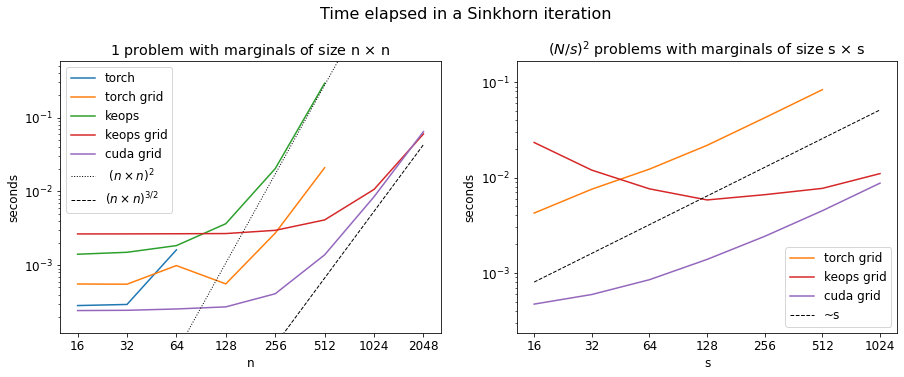

In [14]:
import matplotlib.pyplot as plt
import matplotlib

fig, axs = plt.subplots(ncols = 2, nrows = 1,figsize = (15,5))
#plt.setp(axs, xticks=Ns, xticklabels=[str(int(N)) for N in Ns])

ax = axs[0]
ax.plot(ns, results)
ax.set_yscale("log")
ax.set_xscale("log")
labels = ("torch", "torch grid", "keops", "keops grid", "cuda grid", r"$~(n\times n)^2$", r"$(n\times n)^{3/2}$")
ax.plot(ns, 4e-12*ns**4, lw = 1, ls = ":", color = "k")
ax.plot(ns, 5e-12*ns**(3),lw = 1, ls = "--", color = "k")
ax.set_xlabel("n")
mask_lims = ~torch.isnan(results)
ax.set_ylim([torch.min(results[mask_lims])*0.5, 2*torch.max(results[mask_lims])])
ax.set_xticks(ns, minor = False)
ax.set_xticks([], minor = True)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(labels)
ax.set_title(r"1 problem with marginals of size n $\times$ n")
ax.set_ylabel("seconds")


# Second plot
ax = axs[1]
plt.sca(ax)
ax.plot(cellsizes, results_grid[:,0], c = "tab:orange")
ax.plot(cellsizes, results_grid[:,1], c = "tab:red")
ax.plot(cellsizes, results_grid[:,2], c = "tab:purple")
ax.plot(cellsizes, 5e-5*cellsizes,lw = 1, ls = "--", color = "k")
labels = ("torch grid", "keops grid", "cuda grid", "~s")

mask_lims = ~torch.isnan(results_grid)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([torch.min(results_grid[mask_lims])*0.5, 2*torch.max(results_grid[mask_lims])])
ax.set_xticks(cellsizes, minor = False)
ax.set_xticks([], minor = True)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(labels)

ax.set_title(r"$(N/s)^2$ problems with marginals of size s $\times$ s")
ax.set_xlabel("s")
ax.set_ylabel("seconds")
plt.suptitle("Time elapsed in a Sinkhorn iteration", fontsize = 16, y = 1.03)
plt.savefig("results_benchmark.png", bbox_inches = "tight", dpi = 150, facecolor = "white")